In [1]:
# python
import sys
import importlib
# columnar analysis
from coffea import processor
# local
sidm_path = str(sys.path[0]).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import sidm_processor, llpnanoaodschema, utilities, scaleout
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()

In [2]:
client = scaleout.make_dask_client("tls://localhost:8786")
client

Connection method: Direct,
Dashboard: /user/bryan.cardwell@cern.ch/proxy/8787/status,
Comm: tls://192.168.197.237:8786,Workers: 0
Dashboard: /user/bryan.cardwell@cern.ch/proxy/8787/status,Total threads: 0
Started: 1 hour ago,Total memory: 0 B


In [3]:
samples = [
    '2Mu2E_500GeV_5p0GeV_8p0mm',
    'TTJets',
]

In [4]:
for sample in samples:
    print(sample, utilities.get_xs(sample))

Signal not in xs cfg, assuming 1fb
2Mu2E_500GeV_5p0GeV_8p0mm 0.001
TTJets 471.7


In [5]:
fileset = utilities.make_fileset([samples[0]], "llpNanoAOD_v2", max_files=10, location_cfg="signal_2mu2e_v10.yaml")
fileset = utilities.make_fileset([samples[1]], "llpNanoAOD_v2", max_files=10, location_cfg="backgrounds.yaml", fileset=fileset)
skimmed_fileset = utilities.make_fileset([samples[1]], "skimmed_llpNanoAOD_v2", max_files=10, location_cfg="backgrounds.yaml")

runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    #executor=processor.FuturesExecutor(),
    executor=processor.DaskExecutor(client=client),
    schema=llpnanoaodschema.LLPNanoAODSchema,
    #maxchunks=1,
    skipbadfiles=True,
)

channels = [
    "2mu2e",
]
p = sidm_processor.SidmProcessor(
    channels,
    ["muon_base"],
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]
skimmed_output = runner.run(skimmed_fileset, treename='Events', processor_instance=p)
skimmed_out = skimmed_output["out"]

Signal not in xs cfg, assuming 1fb#######] | 100% Completed | 11min 51.9s
[########################################] | 100% Completed |  3min 37.7s

In [6]:
for sample in samples:
    print(sample, out[sample]["metadata"])
print(sample, skimmed_out[samples[1]]["metadata"])

2Mu2E_500GeV_5p0GeV_8p0mm {'n_evts': 43879, 'scaled_sum_weights': 43879.0}
TTJets {'n_evts': 402863, 'scaled_sum_weights': 402863.0}
TTJets {'n_evts': 109299, 'scaled_sum_weights': 397944.1756619973}


In [7]:
print(samples[0])
out[samples[0]]["cutflow"][channels[0]].print_table()
print()
out[samples[0]]["cutflow"][channels[0]].print_table(unweighted=True)
print()
out[samples[0]]["cutflow"][channels[0]].print_table(fraction=True)
print()

2Mu2E_500GeV_5p0GeV_8p0mm
cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection                 59.8         59.8
pass triggers                22.3         22.3
PV filter                    59.8         22.3
>=2 LJs                      34.0         15.4
2mu2e                        33.8         15.4

cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection              43879.0      43879.0
pass triggers             16375.0      16375.0
PV filter                 43879.0      16375.0
>=2 LJs                   24921.0      11287.0
2mu2e                     24810.0      11258.0

cut name         individual %    marginal %    cumulative %
-------------  --------------  ------------  --------------
No selection            100.0         100.0           100.0
pass triggers            37.3          37.3            37.3
PV filter               100.0         100.0            37.3
>=2 LJs       

In [8]:
print(samples[1])
out[samples[1]]["cutflow"][channels[0]].print_table()
print()
out[samples[1]]["cutflow"][channels[0]].print_table(unweighted=True)
print()
out[samples[1]]["cutflow"][channels[0]].print_table(fraction=True)
print()

TTJets
cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection           28221811.0   28221811.0
pass triggers            483856.9     483856.9
PV filter              28221811.0     483856.9
>=2 LJs                  344030.9       4973.8
2mu2e                     24378.5       3362.5

cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection             402863.0     402863.0
pass triggers              6907.0       6907.0
PV filter                402863.0       6907.0
>=2 LJs                    4911.0         71.0
2mu2e                       348.0         48.0

cut name         individual %    marginal %    cumulative %
-------------  --------------  ------------  --------------
No selection            100.0         100.0           100.0
pass triggers             1.7           1.7             1.7
PV filter               100.0         100.0             1.7
>=2 LJs                   1.2    

In [9]:
print(samples[1], "SKIM")
skimmed_out[samples[1]]["cutflow"][channels[0]].print_table()
print()
skimmed_out[samples[1]]["cutflow"][channels[0]].print_table(unweighted=True)
print()
skimmed_out[samples[1]]["cutflow"][channels[0]].print_table(fraction=True)
print()

TTJets SKIM
cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection            7751378.0    7751378.0
pass triggers            493525.5     493525.5
PV filter               7751378.0     493525.5
>=2 LJs                  289633.3       5106.2
2mu2e                     22126.7       3900.5

cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection             109299.0     109299.0
pass triggers              6959.0       6959.0
PV filter                109299.0       6959.0
>=2 LJs                    4084.0         72.0
2mu2e                       312.0         55.0

cut name         individual %    marginal %    cumulative %
-------------  --------------  ------------  --------------
No selection            100.0         100.0           100.0
pass triggers             6.4           6.4             6.4
PV filter               100.0         100.0             6.4
>=2 LJs                   3.

In [10]:
output.keys()

dict_keys(['out', 'processed', 'exception'])

In [11]:
print(output["processed"])
print(skimmed_output["processed"])

{WorkItem(dataset='TTJets', filename='root://xcache//store/group/lpcmetx/SIDM/Backgrounds/2018_v2/TTJets_TuneCP5/LLPnanoAODv2/TTJets_TuneCP5_part1_part-13.root', treename='Events', entrystart=0, entrystop=40284, fileuuid=b'_\xc7\xff6(\xd9\x11\xef\xa7$R\x15\xe6\x9b\xbe\xef', usermeta={'skim_factor': 1.0}), WorkItem(dataset='2Mu2E_500GeV_5p0GeV_8p0mm', filename='root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v10/BsTo2DpTo2Mu2e/CutDecayFalse_SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-8p0_v3/LLPnanoAODv2/CutDecayFalse_SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-8p0_v3_part-13.root', treename='Events', entrystart=0, entrystop=4407, fileuuid=b'=\xb0\xf8v\xbf\x88\x11\xef\x97\nQ\x15\xe6\x9b\xbe\xef', usermeta={'skim_factor': 1.0}), WorkItem(dataset='2Mu2E_500GeV_5p0GeV_8p0mm', filename='root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v10/BsTo2DpTo2Mu2e/CutDecayFalse_SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-8p0_v3/LLPnanoAODv2/CutDecayFalse_SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-

In [12]:
out[samples[0]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=15.3505, variance=0.0209308),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=26.3092, variance=0.0358731) (WeightedSum(value=26.3133, variance=0.0358787) with flow),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=13.2303, variance=0.0180398) (WeightedSum(value=26.3133, variance=0.0358787) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=26.3105, va

In [13]:
out[samples[1]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=3362.55, variance=235557),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=8686.59, variance=608523),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=4273.24, variance=299354) (WeightedSum(value=8686.59, variance=608523) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=8686.59, variance=608523),
 'muon_absD0': Hist(
   StrCategory(['2mu2e'], name='ch

In [14]:
skimmed_out[samples[1]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=3900.55, variance=276623),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=10070.5, variance=714190),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=5035.25, variance=357095) (WeightedSum(value=10070.5, variance=714190) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=10070.5, variance=714190),
 'muon_absD0': Hist(
   StrCategory(['2mu2e'], name='ch

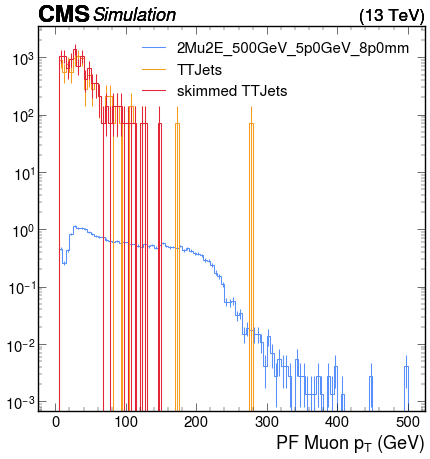

In [15]:
legend = [*samples, f"skimmed {samples[1]}"]
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_pt"][channels[0], :])
utilities.plot(skimmed_out[samples[1]]["hists"]["muon_pt"][channels[0], :])
plt.yscale("log")
plt.legend(legend)

In [16]:
p_unweighted = sidm_processor.SidmProcessor(
    channels,
    ["muon_base"],
    unweighted_hist=True,
)

output_unweighted = runner.run(fileset, treename='Events', processor_instance=p_unweighted)
out_unweighted = output_unweighted["out"]
skimmed_output_unweighted = runner.run(fileset, treename='Events', processor_instance=p_unweighted)
skimmed_out_unweighted = skimmed_output_unweighted["out"]

Signal not in xs cfg, assuming 1fb#######] | 100% Completed |  8min 41.5s
Signal not in xs cfg, assuming 1fb#######] | 100% Completed |  9min  7.1s


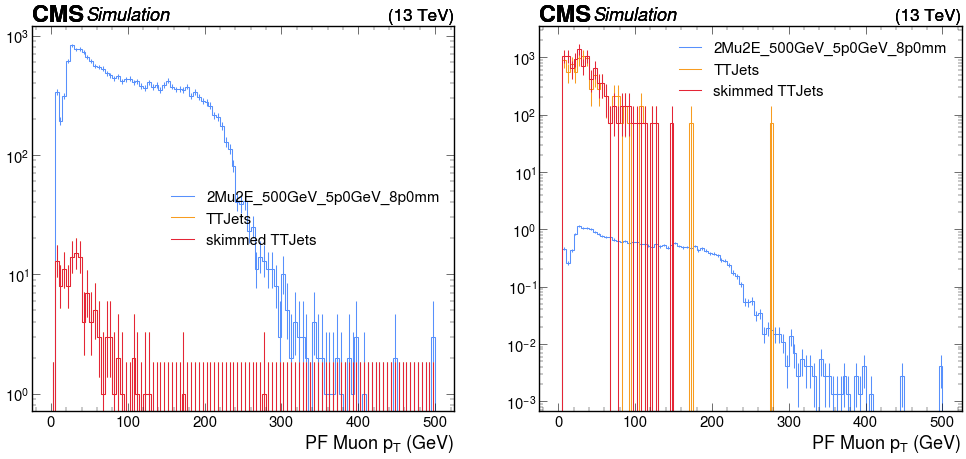

In [17]:
plt.subplots(1, 2, figsize=(2*12, 10))
plt.subplot(1, 2, 1)
for sample in samples:
    utilities.plot(out_unweighted[sample]["hists"]["muon_pt"][channels[0], :])
utilities.plot(skimmed_out_unweighted[samples[1]]["hists"]["muon_pt"][channels[0], :])
plt.yscale("log")
plt.legend(legend)
plt.subplot(1, 2, 2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_pt"][channels[0], :])
utilities.plot(skimmed_out[samples[1]]["hists"]["muon_pt"][channels[0], :])
plt.yscale("log")
plt.legend(legend)

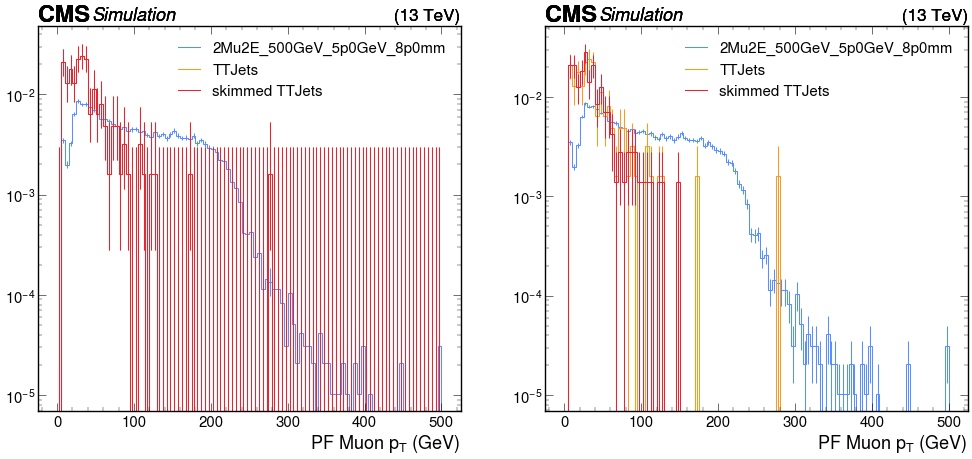

In [18]:
plt.subplots(1, 2, figsize=(2*12, 10))
plt.subplot(1, 2, 1)
for sample in samples:
    utilities.plot(out_unweighted[sample]["hists"]["muon_pt"][channels[0], :], density=True)
utilities.plot(skimmed_out_unweighted[sample]["hists"]["muon_pt"][channels[0], :], density=True)
plt.yscale("log")
plt.legend(legend)
plt.subplot(1, 2, 2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_pt"][channels[0], :], density=True)
utilities.plot(skimmed_out[sample]["hists"]["muon_pt"][channels[0], :], density=True)
plt.yscale("log")
plt.legend(legend)

In [19]:
out_unweighted[samples[0]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=11258, variance=11258),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=19295, variance=19295) (WeightedSum(value=19298, variance=19298) with flow),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=9703, variance=9703) (WeightedSum(value=19298, variance=19298) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=19296, variance=19296) (WeightedSum(value=1

In [20]:
out_unweighted[samples[1]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=48, variance=48),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=124, variance=124),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=61, variance=61) (WeightedSum(value=124, variance=124) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=124, variance=124),
 'muon_absD0': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='

In [21]:
skimmed_out_unweighted[samples[1]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=48, variance=48),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=124, variance=124),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=61, variance=61) (WeightedSum(value=124, variance=124) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=124, variance=124),
 'muon_absD0': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='